In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
import stockstats
from pandas.tseries.holiday import USFederalHolidayCalendar
from fredapi import Fred
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, MaxPooling1D
from tensorflow.keras.regularizers import l2
from joblib import Parallel, delayed
import seaborn as sns
sns.set(style="whitegrid")

tweets_df = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\code_archive_diss\test_csvs\volume.csv')
tweets_df = tweets_df[tweets_df['ticker_symbol']=='AAPL']
tweets_df.rename(columns={'market_date': 'date'}, inplace=True)
tweets_df['date'] = pd.to_datetime(tweets_df['date'])

def fetch_stock_data(ticker, start_date, end_date):
    # return pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\models\aapl_stocks_2015_2019.csv')
    return yf.download(ticker, start=start_date, end=end_date)

def add_technical_indicators(data):

    """
    daily_return and volatility definitely use current day's information.
    obv and roc likely use current day's information.
    Technical indicators from stockstats need verification. (sma_20, ema_20, rsi_14, macd)
    vix and usdx alignment might introduce look-ahead bias.
    Tweet sentiment data timing needs verification.
    """
    stock = stockstats.StockDataFrame.retype(data)
    
    data['sma_20'] = stock['close_20_sma']
    data['ema_20'] = stock['close_20_ema']
    data['rsi_14'] = stock['rsi_14']
    data['macd'] = stock['macd'] - stock['macds']
    data['boll'] = stock['boll']
    data['boll_ub'] = stock['boll_ub']
    data['boll_lb'] = stock['boll_lb']
    data['cci_14'] = stock['cci_14']
    data['atr_14'] = stock['atr_14']
    
    data['day_of_week'] = data.index.dayofweek
    data['month'] = data.index.month
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=data.index.min(), end=data.index.max())
    data['is_holiday'] = data.index.isin(holidays).astype(int)

    # Custom calculated indicators - need shifting
    data['daily_return'] = data['close'].pct_change().shift(1)
    data['volatility'] = data['daily_return'].rolling(window=20).std().shift(1) * np.sqrt(252)
    data['obv'] = (np.sign(data['close'].diff()) * data['volume']).cumsum().shift(1)
    data['roc'] = data['close'].pct_change(periods=12).shift(1)
    
    # External data - shift VIX and USDX
    vix_data = yf.download('^VIX', start=data.index.min(), end=data.index.max())
    usdx_data = yf.download('DX-Y.NYB', start=data.index.min(), end=data.index.max())
    data['vix'] = vix_data['Close'].reindex(data.index, method='ffill').shift(1)
    data['usdx'] = usdx_data['Close'].reindex(data.index, method='ffill').shift(1)
    
    # FRED API data - assuming correct alignment, no shift needed
    fred = Fred(api_key="9bdd17c1e9c9a71b4fabb8dc5636314d")
    data['gdp_growth'] = fred.get_series('A191RL1Q225SBEA').reindex(data.index, method='ffill')
    data['interest_rate'] = fred.get_series('DFF').reindex(data.index, method='ffill')
    data['inflation_rate'] = fred.get_series('CPIAUCSL').pct_change(12).reindex(data.index, method='ffill')
    data['effr'] = fred.get_series('EFFR').reindex(data.index, method='ffill')
    data['unemployment_rate'] = fred.get_series('UNRATE').reindex(data.index, method='ffill')
    data['consumer_sentiment'] = fred.get_series('UMCSENT').reindex(data.index, method='ffill')
    
    return data

def prepare_sequences(data, features, target_column, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:(i + sequence_length)].values)
        y.append(data[target_column].iloc[i + sequence_length])
    return np.array(X), np.array(y)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def plot_results(y_true, y_pred, title, history):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_true)), y_true, label='Actual')
    plt.plot(range(len(y_true)), y_pred, label='Predicted')
    plt.legend()
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

ticker = "AAPL"
start_date = '2015-01-01'
end_date = '2019-12-31'
target_column = 'close'
sequence_length = 30
indicators = ['close']
stock_data = fetch_stock_data(ticker, start_date, end_date)

stock_data = add_technical_indicators(stock_data)

if indicators:
    for indicator in indicators:
        stock_data[f'{indicator}_lag_1'] = stock_data[f'{indicator}'].shift(1)
        stock_data[f'{indicator}_lag_5'] = stock_data[f'{indicator}'].shift(5)
        stock_data[f'{indicator}_lag_10'] = stock_data[f'{indicator}'].shift(10)
# _______________________________________________________________________________________________________
"""
tweets_df['negative_sentiment_times_engagement'] = tweets_df.avg_negative_sentiment * tweets_df.avg_engagement_per_tweet
tweets_df['negative_sentiment_times_reach'] = tweets_df.avg_negative_sentiment * tweets_df.avg_reach_per_tweet
tweets_df['positive_sentiment_times_engagement'] = tweets_df.avg_positive_sentiment * tweets_df.avg_engagement_per_tweet
tweets_df['positive_sentiment_times_reach'] = tweets_df.avg_positive_sentiment * tweets_df.avg_reach_per_tweet
tweets_df['neutral_sentiment_times_engagement'] = tweets_df.avg_neutral_sentiment * tweets_df.avg_engagement_per_tweet
tweets_df['neutral_sentiment_times_reach'] = tweets_df.avg_neutral_sentiment * tweets_df.avg_reach_per_tweet
"""
# _______________________________________________________________________________________________________

# tweet_data = tweets_df[tweets_df['ticker_symbol'] == ticker]
tweet_data = tweets_df
combined_data = pd.merge(stock_data.reset_index(), tweet_data, left_on='Date', right_on='date', how='left')
combined_data.set_index('Date', inplace=True)
# combined_data.to_csv('./csvs/combined.csv', index=False)
# combined_data = pd.read_csv('./csvs/combined.csv')
from sklearn.feature_selection import mutual_info_regression


og_features = [            
            # STOCKS
            'open', 'high', 'low',

            # CALENDAR
            'day_of_week', 
            'month', 
            'is_holiday', # -ve 
            
            # INDICATORS
            'vix', 
            'usdx',
            'obv', 
            'roc', 
            'boll', 'boll_ub', 'boll_lb', 'cci_14', 
            'atr_14', # -ve 
            'volatility', 
            'daily_return',     
            'effr', # -ve 
            'sma_20', 'ema_20', 'macd', # MAY INTRODUCE LAG
            'rsi_14',
            # MACROS 
            'unemployment_rate', 
            'consumer_sentiment', # -ve
            'gdp_growth', 
            'interest_rate', # -ve
            'inflation_rate'
            ]

tweets_columns = ['tweet_volume', 'avg_sentiment', 'avg_neutral_sentiment',
       'avg_positive_sentiment', #-ve 
       'avg_negative_sentiment', 'nmf_topic_0_avg',
       'nmf_topic_1_avg', 'nmf_topic_2_avg', #-ve 
       'nmf_topic_3_avg', 'nmf_topic_4_avg', 'nmf_topic_5_avg', 'nmf_topic_6_avg', 'nmf_topic_7_avg', 
       'nmf_topic_8_avg', #-ve
       'total_reach',
       'avg_reach_per_tweet', 'total_engagement', 'avg_engagement_per_tweet']
og_features += tweets_columns
# og_features = og_features+list(tweets_df.columns[2::])

for i in [0,5,6,7]:
    og_features.remove(f"nmf_topic_{i}_avg")

remove = ['total_reach',
'nmf_topic_3_avg',
'avg_positive_sentiment',
'nmf_topic_8_avg',
'tweet_volume',
'nmf_topic_4_avg',
'gdp_growth',
'atr_14',
'volatility',
'effr'
]
og_features = [s for s in og_features if s not in remove]

if indicators:
    for indicator in indicators:
        og_features.extend([f'{indicator}_lag_1', f'{indicator}_lag_5', f'{indicator}_lag_10'])

combined_data = combined_data.dropna()

# ________________________________________________________________________________________________________________________
"""  
Uses mutual information to identify important features.
Among important features, it identifies highly correlated groups.
It keeps all important features that aren't highly correlated with others.
For highly correlated groups, it keeps at least one feature.
"""

def balanced_feature_selection(data, features, target, importance_threshold=0.001, correlation_threshold=0.95):
    mi_scores = mutual_info_regression(data[features], data[target])
    mi_scores = pd.Series(mi_scores, index=features)
    important_features = mi_scores[mi_scores > importance_threshold].index.tolist()
    
    corr_matrix = data[important_features].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]
    
    final_features = [f for f in important_features if f not in to_drop]
    final_features.extend(to_drop[:1])  
    
    print(f"Selected {len(final_features)} features out of {len(features)} original features")
    print("Selected features:", final_features)
    print(f"Removed features:{to_drop}")
    
    return final_features

target_column = 'close'
features = balanced_feature_selection(combined_data, og_features, target_column)
features.extend(['close_lag_1', 'close_lag_5', 'close_lag_10'])

train_size = int(len(combined_data) * 0.8)
train_data = combined_data.iloc[:train_size]
val_data = combined_data.iloc[train_size:]

scaler = MinMaxScaler()

train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data[features + ['close']]),
                                columns=features + ['close'], 
                                index=train_data.index)

val_data_scaled = pd.DataFrame(scaler.transform(val_data[features + ['close']]),
                            columns=features + ['close'], 
                            index=val_data.index)

X_train, y_train = prepare_sequences(train_data_scaled, features, target_column, sequence_length)
X_val, y_val = prepare_sequences(val_data_scaled, features, target_column, sequence_length)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Selected 21 features out of 34 original features
Selected features: ['open', 'month', 'vix', 'usdx', 'obv', 'roc', 'cci_14', 'macd', 'rsi_14', 'unemployment_rate', 'consumer_sentiment', 'interest_rate', 'inflation_rate', 'avg_sentiment', 'avg_neutral_sentiment', 'avg_negative_sentiment', 'nmf_topic_1_avg', 'nmf_topic_2_avg', 'avg_reach_per_tweet', 'total_engagement', 'high']
Removed features:['high', 'low', 'boll', 'boll_ub', 'boll_lb', 'sma_20', 'ema_20', 'avg_engagement_per_tweet', 'close_lag_1', 'close_lag_5', 'close_lag_10']


XGBoost - MAE: 3.5513, RMSE: 5.7851, R2: 0.4169


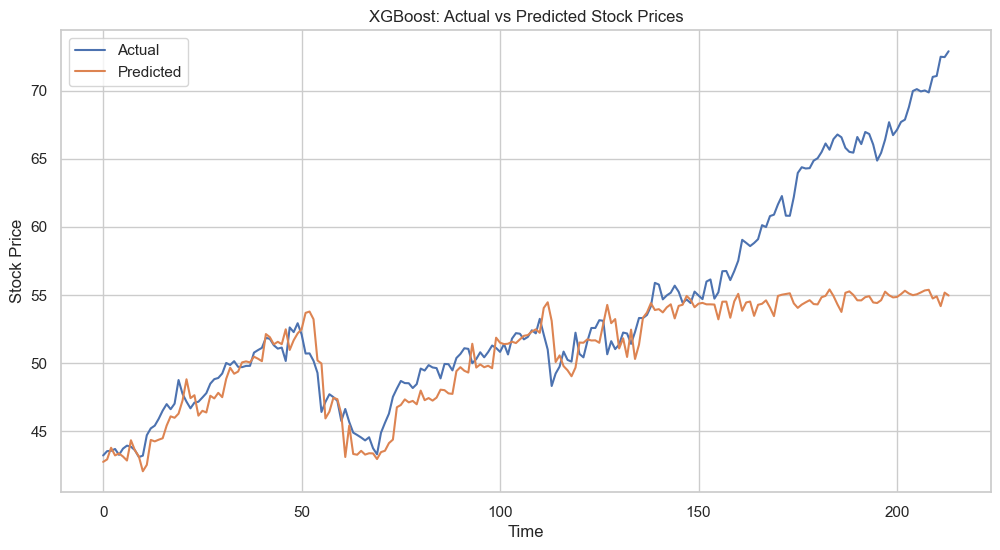

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149941
[LightGBM] [Info] Number of data points in the train set: 945, number of used features: 720
[LightGBM] [Info] Start training from score 0.372650
LightGBM - MAE: 3.2199, RMSE: 5.4926, R2: 0.4744


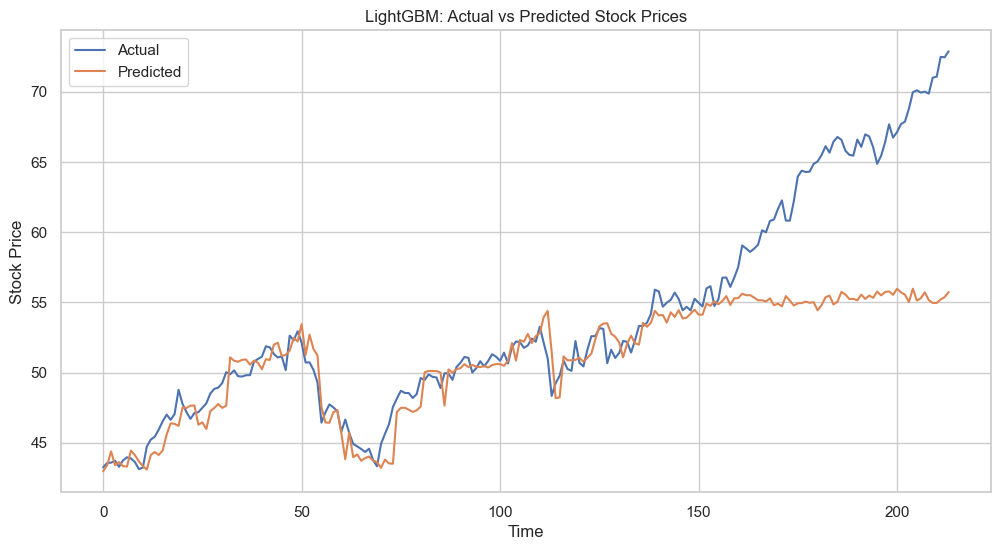

c:\Users\Adil Rehman\clean\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0400 - mae: 0.1415 - val_loss: 0.0250 - val_mae: 0.1123 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0111 - mae: 0.0757 - val_loss: 0.0212 - val_mae: 0.1033 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0093 - mae: 0.0672 - val_loss: 0.0119 - val_mae: 0.0817 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0078 - mae: 0.0625 - val_loss: 0.0098 - val_mae: 0.0690 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0082 - mae: 0.0648 - val_loss: 0.0148 - val_mae: 0.0846 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0113 - mae: 0.0735 - val_loss: 0.0099 - val_mae: 0.0746 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0078 - mae: 0.0615 - val_loss: 0.0206 - val_mae: 0.1136 - learning_rate: 0.0010
Epoch 

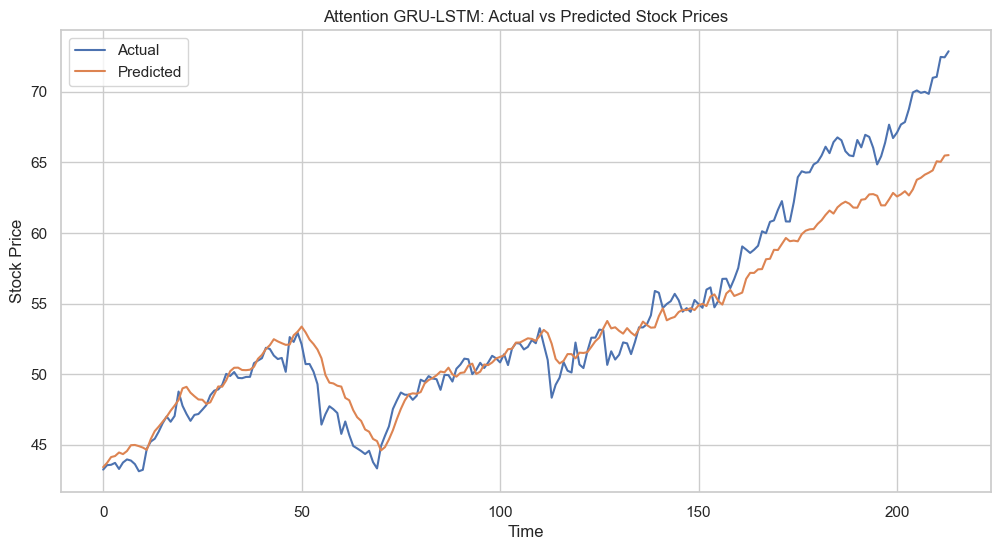

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.1373 - mae: 0.2929 - val_loss: 0.1595 - val_mae: 0.3484 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0121 - mae: 0.0831 - val_loss: 0.0627 - val_mae: 0.2035 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0060 - mae: 0.0581 - val_loss: 0.0252 - val_mae: 0.1139 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035 - mae: 0.0458 - val_loss: 0.0167 - val_mae: 0.0948 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034 - mae: 0.0452 - val_loss: 0.0189 - val_mae: 0.1002 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - mae: 0.0425 - val_loss: 0.0155 - val_mae: 0.0943 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026 - mae: 0.0384 - val_loss: 0.0179 - val_mae: 0.1033 - learning_rate: 0.0010
Epoch 

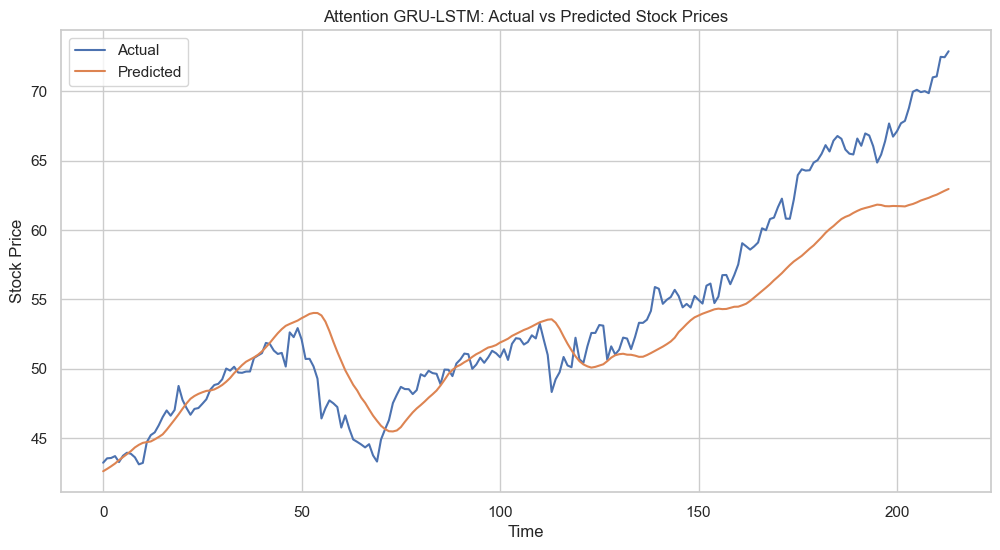

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0654 - mae: 0.2597 - val_loss: 0.0670 - val_mae: 0.3225 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - mae: 0.1010 - val_loss: 0.0102 - val_mae: 0.0934 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - mae: 0.0660 - val_loss: 0.0155 - val_mae: 0.1381 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0599 - val_loss: 0.0090 - val_mae: 0.0960 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - mae: 0.0561 - val_loss: 0.0097 - val_mae: 0.1043 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0554 - val_loss: 0.0084 - val_mae: 0.0950 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - mae: 0.0534 - val_loss: 0.0077 - val_mae: 0.0904 - learning_rate: 0.0010
Epoch 8/100

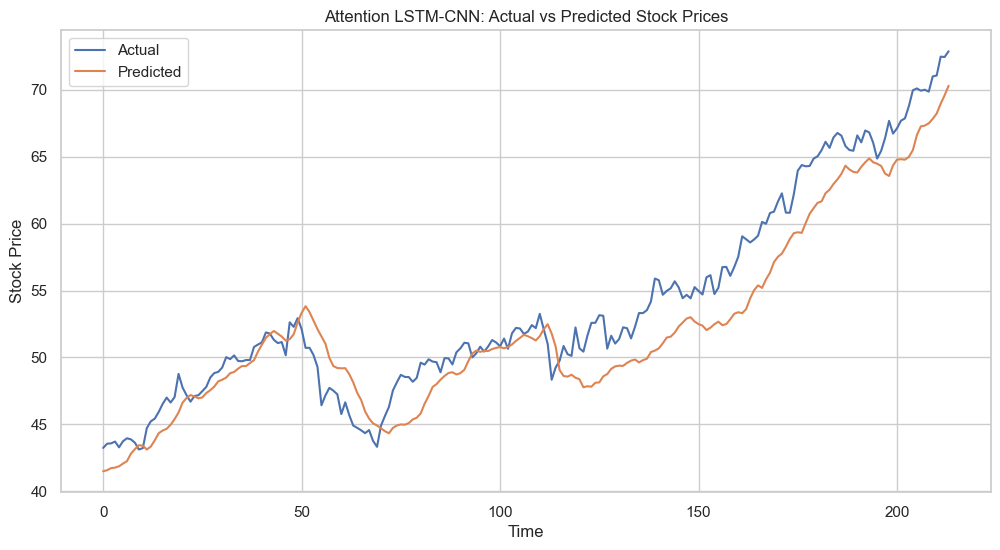

DeepESN - MAE: 1.5533, RMSE: 2.0701, R2: 0.9253


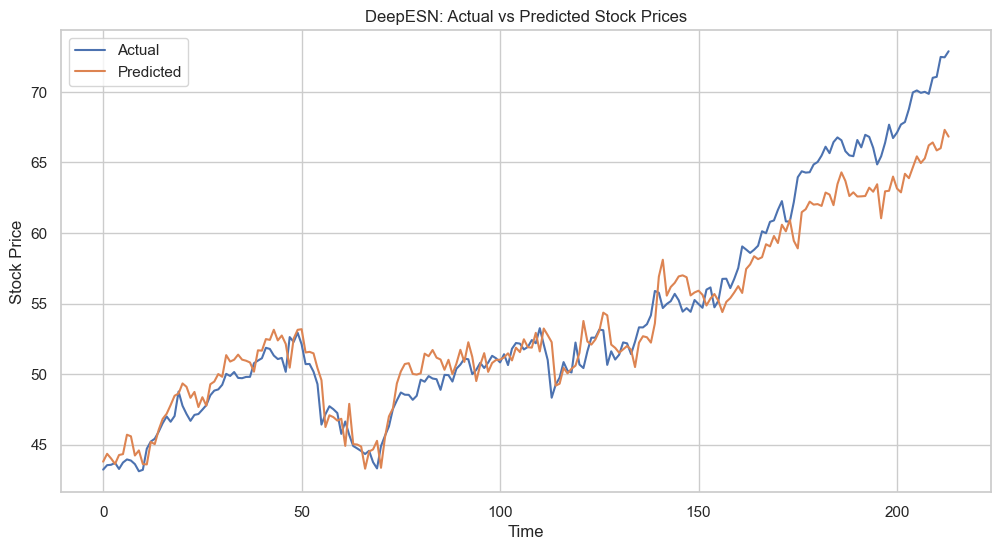


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 10.9417 - mae: 2.0207 - val_loss: 0.0881 - val_mae: 0.1185 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2221 - mae: 0.3045 - val_loss: 0.1342 - val_mae: 0.2258 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1283 - mae: 0.1928 - val_loss: 0.1279 - val_mae: 0.1961 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1025 - mae: 0.1532 - val_loss: 0.1573 - val_mae: 0.2663 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0921 - mae: 0.1279 - val_loss: 0.1709 - val_mae: 0.2905 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0865 - mae: 0.1198 - val_loss: 0.1914 - val_mae: 0.3239 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0832 - mae: 0.1117 - val_loss: 0.1834 - val_mae: 0.3121 - learning_rate: 1.0000e-04


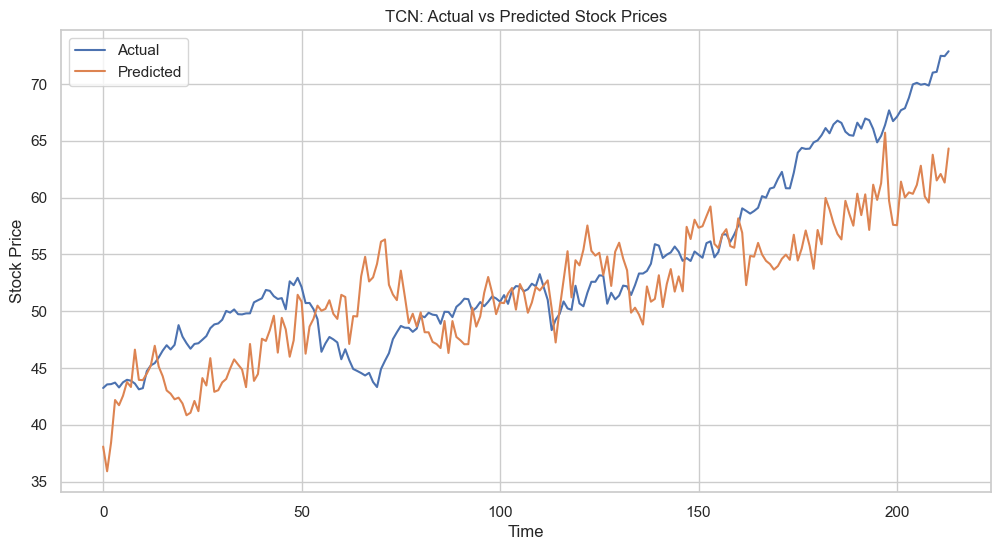

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 14.6463 - mae: 2.4111 - val_loss: 0.0761 - val_mae: 0.0697 - learning_rate: 0.0010
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1979 - mae: 0.2853 - val_loss: 0.1070 - val_mae: 0.1769 - learning_rate: 0.0010
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1492 - mae: 0.2214 - val_loss: 0.1526 - val_mae: 0.2793 - learning_rate: 0.0010
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1143 - mae: 0.1691 - val_loss: 0.1337 - val_mae: 0.2410 - learning_rate: 0.0010
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1022 - mae: 0.1540 - val_loss: 0.1487 - val_mae: 0.2712 - learning_rate: 0.0010
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0959 - mae: 0.1397 - val_loss: 0.1337 - val_mae: 0.2449 - learning_rate: 0.0010
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0931 - mae: 0.1302 - val_loss: 0.1270 - val_mae: 0.2308 - learning_rate: 1.0000e-04
E

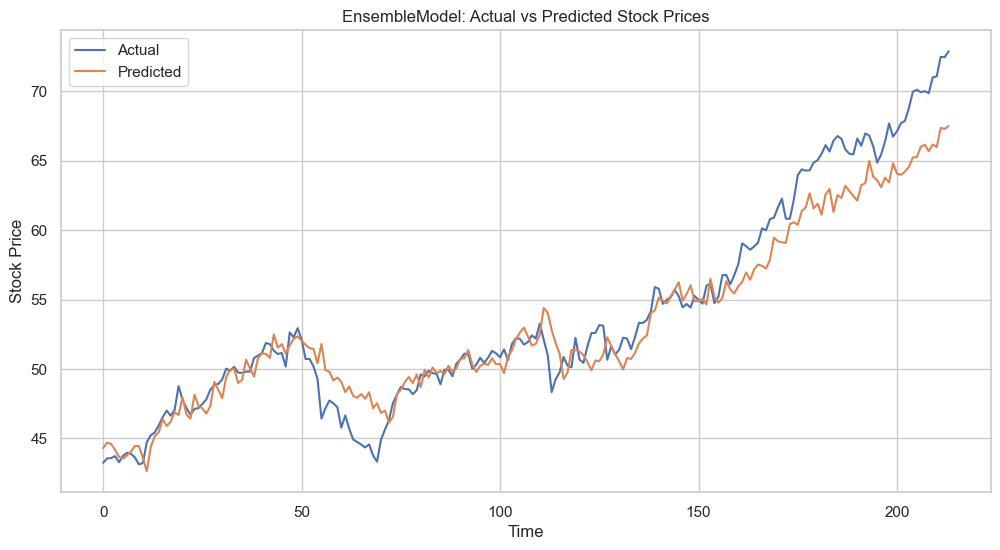

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 10.8488 - mae: 2.0446 - val_loss: 0.2368 - val_mae: 0.3766 - learning_rate: 0.0010
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1394 - mae: 0.2042 - val_loss: 0.1948 - val_mae: 0.3207 - learning_rate: 0.0010
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1043 - mae: 0.1465 - val_loss: 0.2007 - val_mae: 0.3375 - learning_rate: 0.0010
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0999 - mae: 0.1340 - val_loss: 0.1581 - val_mae: 0.2741 - learning_rate: 0.0010
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0961 - mae: 0.1312 - val_loss: 0.1618 - val_mae: 0.2867 - learning_rate: 0.0010
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0869 - mae: 0.1105 - val_loss: 0.1319 - val_mae: 0.2327 - learning_rate: 0.0010
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0822 - mae: 0.0967 - val_loss: 0.1192 - val_mae: 0.2055 - learning_rate: 0.0010
Epoch

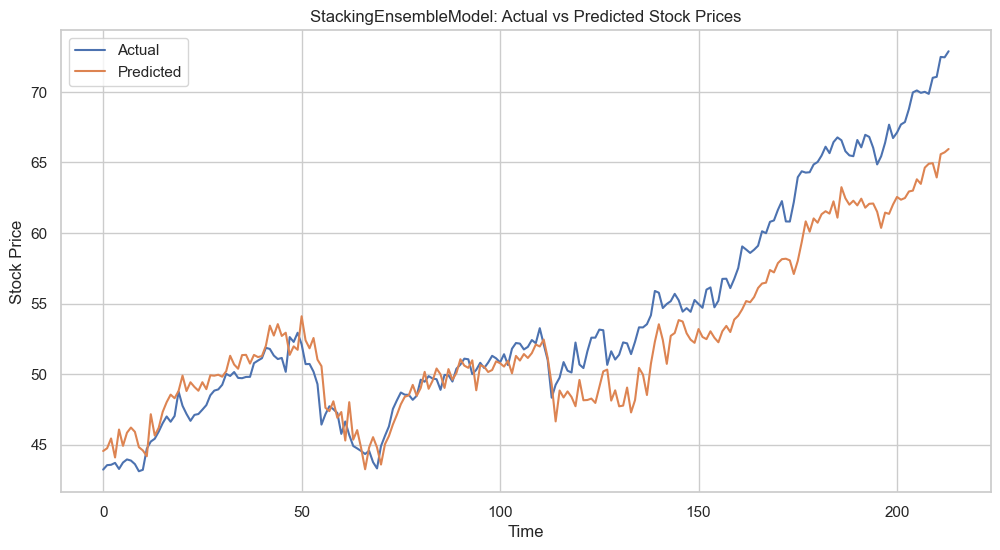


Summary of Results:
XGBoost - MAE: 3.5513, RMSE: 5.7851, R2: 0.4169
LightGBM - MAE: 3.2199, RMSE: 5.4926, R2: 0.4744
GRU-LSTM - MAE: 1.7169, RMSE: 2.4607, R2: 0.8945
Attention GRU-LSTM - MAE: 2.5922, RMSE: 3.4677, R2: 0.7905
Attention LSTM-CNN - MAE: 2.2327, RMSE: 2.6278, R2: 0.8797
DeepESN - MAE: 1.5533, RMSE: 2.0701, R2: 0.9253
TCN - MAE: 4.1166, RMSE: 5.0822, R2: 0.5500
Ensemble Model - MAE: 1.5538, RMSE: 2.0896, R2: 0.9239
Stacking Ensemble Model - MAE: 2.3349, RMSE: 2.9346, R2: 0.8500


In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from models import *
import xgboost as xgb
import lightgbm as lgb 

def prepare_sequences(data, features, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:(i + sequence_length)].values)
        y.append(data[target].iloc[i + sequence_length])
    return np.array(X), np.array(y)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def plot_results(y_true, y_pred, title, history=None):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
    if history:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# Data preparation
train_size = int(len(combined_data) * 0.8)
train_data = combined_data.iloc[:train_size]
val_data = combined_data.iloc[train_size:]

scaler = MinMaxScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data[features + ['close']]),
                                 columns=features + ['close'], 
                                 index=train_data.index)
val_data_scaled = pd.DataFrame(scaler.transform(val_data[features + ['close']]),
                               columns=features + ['close'], 
                               index=val_data.index)

sequence_length = 30
X_train, y_train = prepare_sequences(train_data_scaled, features, target_column, sequence_length)
X_val, y_val = prepare_sequences(val_data_scaled, features, target_column, sequence_length)

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    if model_name in ['XGBoost', 'LightGBM']:
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        X_val_2d = X_val.reshape(X_val.shape[0], -1)
        model.fit(X_train_2d, y_train)
        y_pred = model.predict(X_val_2d)
    elif model_name in ['DeepESN']:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    elif model_name in ['EnsembleModel', 'StackingEnsembleModel']:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
        callbacks = [early_stopping, lr_scheduler]
        model.fit(X_train, y_train, (X_val, y_val), epochs=200, callbacks=callbacks)
        y_pred = model.predict(X_val)
    else:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
        callbacks = [early_stopping, lr_scheduler]
        model.fit(X_train, y_train, epochs=100, batch_size=32, 
                  validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)
        y_pred = model.predict(X_val)
    
    y_val_inv = scaler.inverse_transform(np.column_stack((np.zeros((len(y_val), len(features))), y_val)))[:, -1]
    y_pred_inv = scaler.inverse_transform(np.column_stack((np.zeros((len(y_pred), len(features))), y_pred.flatten())))[:, -1]
    
    mae, rmse, r2 = evaluate_model(y_val_inv, y_pred_inv)
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    
    plot_results(y_val_inv, y_pred_inv, f'{model_name}: Actual vs Predicted Stock Prices')
    
    return mae, rmse, r2

# XGBoost
xgb_model = xgb.XGBRegressor(learning_rate=0.3, max_depth=10, n_estimators=1000, random_state=42)
xgb_mae, xgb_rmse, xgb_r2 = train_and_evaluate(xgb_model, X_train, y_train, X_val, y_val, "XGBoost")

# LightGBM
lgb_model = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=200, num_leaves=31, random_state=42)
lgb_mae, lgb_rmse, lgb_r2 = train_and_evaluate(lgb_model, X_train, y_train, X_val, y_val, "LightGBM")

# ESN-LSTM
# esn_lstm_model = ESN_LSTM(X_train.shape[1:], reservoir_size=300, lstm_units=200, l2_reg=1e-4)
# esn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
# esn_lstm_mae, esn_lstm_rmse, esn_lstm_r2 = train_and_evaluate(esn_lstm_model, X_train, y_train, X_val, y_val, "ESN-LSTM")

# Attention GRU-LSTM
gru_lstm_model = gru_lstm((sequence_length, len(features)), l2_val=0)
gru_lstm_mae, gru_lstm_rmse, gru_lstm_r2 = train_and_evaluate(gru_lstm_model, X_train, y_train, X_val, y_val, "Attention GRU-LSTM")

# Attention GRU-LSTM
att_gru_lstm_model = att_gru_lstm((sequence_length, len(features)), l2_val=0)
att_gru_lstm_mae, att_gru_lstm_rmse, att_gru_lstm_r2 = train_and_evaluate(att_gru_lstm_model, X_train, y_train, X_val, y_val, "Attention GRU-LSTM")

# Attention LSTM-CNN
att_lstm_cnn_model = att_lstm_cnn((sequence_length, len(features)), l2_val=5e-5)
att_lstm_cnn_mae, att_lstm_cnn_rmse, att_lstm_cnn_r2 = train_and_evaluate(att_lstm_cnn_model, X_train, y_train, X_val, y_val, "Attention LSTM-CNN")

# DeepESN
deep_esn_model = DeepESN(n_inputs=len(features), n_reservoir=80, n_outputs=1, n_layers=3)
deep_esn_mae, deep_esn_rmse, deep_esn_r2 = train_and_evaluate(deep_esn_model, X_train, y_train, X_val, y_val, "DeepESN")

# TCN
tcn_model = tcn((sequence_length, len(features)))
tcn_mae, tcn_rmse, tcn_r2 = train_and_evaluate(tcn_model, X_train, y_train, X_val, y_val, "TCN")

# Ensemble Model
ensemble_model = EnsembleModel((sequence_length, len(features)), len(features))
ensemble_mae, ensemble_rmse, ensemble_r2 = train_and_evaluate(ensemble_model, X_train, y_train, X_val, y_val, "EnsembleModel")

# Stacking Ensemble Model
stacking_ensemble_model = StackingEnsembleModel((sequence_length, len(features)), len(features))
stacking_ensemble_mae, stacking_ensemble_rmse, stacking_ensemble_r2 = train_and_evaluate(stacking_ensemble_model, X_train, y_train, X_val, y_val, "StackingEnsembleModel")

print("\nSummary of Results:")
print(f"XGBoost - MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}, R2: {xgb_r2:.4f}")
print(f"LightGBM - MAE: {lgb_mae:.4f}, RMSE: {lgb_rmse:.4f}, R2: {lgb_r2:.4f}")
# print(f"ESN-LSTM - MAE: {esn_lstm_mae:.4f}, RMSE: {esn_lstm_rmse:.4f}, R2: {esn_lstm_r2:.4f}")
print(f"GRU-LSTM - MAE: {gru_lstm_mae:.4f}, RMSE: {gru_lstm_rmse:.4f}, R2: {gru_lstm_r2:.4f}")
print(f"Attention GRU-LSTM - MAE: {att_gru_lstm_mae:.4f}, RMSE: {att_gru_lstm_rmse:.4f}, R2: {att_gru_lstm_r2:.4f}")
print(f"Attention LSTM-CNN - MAE: {att_lstm_cnn_mae:.4f}, RMSE: {att_lstm_cnn_rmse:.4f}, R2: {att_lstm_cnn_r2:.4f}")
print(f"DeepESN - MAE: {deep_esn_mae:.4f}, RMSE: {deep_esn_rmse:.4f}, R2: {deep_esn_r2:.4f}")
print(f"TCN - MAE: {tcn_mae:.4f}, RMSE: {tcn_rmse:.4f}, R2: {tcn_r2:.4f}")
print(f"Ensemble Model - MAE: {ensemble_mae:.4f}, RMSE: {ensemble_rmse:.4f}, R2: {ensemble_r2:.4f}")
print(f"Stacking Ensemble Model - MAE: {stacking_ensemble_mae:.4f}, RMSE: {stacking_ensemble_rmse:.4f}, R2: {stacking_ensemble_r2:.4f}")


____

# TRAIN VALIDATE TEST + SYNTHETIC DATA

In [3]:
# _________________________________________________________________________
def prepare_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:(i + sequence_length)].values)
        y.append(data.iloc[i + sequence_length][target_column])
    return np.array(X), np.array(y)

train_size = int(0.7 * len(combined_data))
val_size = int(0.15 * len(combined_data))

train_data = combined_data[:train_size]
val_data = combined_data[train_size:train_size+val_size]
test_data = combined_data[train_size+val_size:]

synthetic_data = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\models\csvs\synth_data_2021-02-03.csv', index_col=0, parse_dates=True)
synthetic_data = synthetic_data.head(500)

train_data_augmented = pd.concat([train_data, synthetic_data]).sort_index()

train_data_augmented = train_data_augmented.ffill().bfill()

scaler = MinMaxScaler()
scaler.fit(train_data_augmented[features + ['close']])

train_data_scaled = pd.DataFrame(
    scaler.transform(train_data_augmented[features + ['close']]),
    columns=features + ['close'],
    index=train_data_augmented.index
)
val_data_scaled = pd.DataFrame(
    scaler.transform(val_data[features + ['close']]),
    columns=features + ['close'],
    index=val_data.index
)
test_data_scaled = pd.DataFrame(
    scaler.transform(test_data[features + ['close']]),
    columns=features + ['close'],
    index=test_data.index
)

sequence_length = 30  
X_train, y_train = prepare_sequences(train_data_scaled, sequence_length)
X_val, y_val = prepare_sequences(val_data_scaled, sequence_length)
X_test, y_test = prepare_sequences(test_data_scaled, sequence_length)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
# _________________________________________________________________________


Training set shape: (1223, 30, 25)
Validation set shape: (152, 30, 25)
Test set shape: (154, 30, 25)


In [13]:
gru_lstm_param_grid = {
    'gru_units': [32, 64, 128],
    'lstm_units': [25, 50, 100],
    'dense_units': [32, 64],
}

att_gru_lstm_param_grid = {
    'gru_units': [32, 64, 128],
    'lstm_units': [25, 50, 100],
    'dense_units': [32, 64],
}

att_lstm_cnn_param_grid = {
    'conv_filters': [32, 64, 128],
    'conv_kernel_size': [2, 3, 4],
    'lstm_units': [25, 50, 100],
    'dense_units': [32, 64],
}

tcn_param_grid = {
    'nb_filters': [32, 64, 128],
    'kernel_size': [2, 3, 4],
    'nb_stacks': [1, 2],
    'dilations': [[1, 2, 4, 8], [1, 2, 4, 8, 16], [1, 2, 4, 8, 16, 32]],
    'learning_rate': [0.01]
}

deep_esn_param_grid = {
    'n_reservoir': [100, 200, 300],
    'n_layers': [2, 3, 4],
    'spectral_radius': [0.8, 0.9, 1.0],
    'sparsity': [0, 0.1, 0.2],
    'leaking_rate': [0.5, 0.8, 1.0],
    # 'ridge_param': [1e-4, 1e-3, 1e-2]
}


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from models import *
from tqdm import tqdm
from tqdm.keras import TqdmCallback

def prepare_sequences(data, features, target, sequence_length):
    X = np.lib.stride_tricks.sliding_window_view(data[features].values, (sequence_length, len(features)))
    y = data[target].values[sequence_length:]
    return X.reshape(-1, sequence_length, len(features)), y

def evaluate_model(y_true, y_pred):
    return (
        mean_absolute_error(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        r2_score(y_true, y_pred)
    )

def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def create_model(model_fn, input_shape, **kwargs):
    if model_fn.__name__ == 'DeepESN':
        return model_fn(n_inputs=input_shape[-1], **kwargs)
    return model_fn(input_shape, **kwargs)


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from models import *
from tqdm import tqdm
from tqdm.keras import TqdmCallback

def prepare_sequences(data, features, target, sequence_length):
    X = np.lib.stride_tricks.sliding_window_view(data[features].values, (sequence_length, len(features)))
    y = data[target].values[sequence_length:]
    return X.reshape(-1, sequence_length, len(features)), y

def evaluate_model(y_true, y_pred):
    return (
        mean_absolute_error(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        r2_score(y_true, y_pred)
    )

def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def create_model(model_fn, input_shape, **kwargs):
    if model_fn.__name__ == 'DeepESN':
        return model_fn(n_inputs=input_shape[-1], **kwargs)
    return model_fn(input_shape, **kwargs)

def train_and_evaluate_model(model_fn, input_shape, params, X_train, y_train, X_val, y_val):
    model = create_model(model_fn, input_shape, **params)
    
    if model_fn.__name__ == 'DeepESN':
        model.fit(X_train, y_train)
        val_loss = mean_squared_error(y_val, model.predict(X_val))
    else:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
        
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val, y_val),
            # callbacks=[early_stopping, lr_scheduler],
            verbose=0  
        )
        val_loss = min(history.history['val_loss'])
    
    return model, val_loss

def custom_hyperparameter_tuning(model_fn, param_grid, X_train, y_train, X_val, y_val, input_shape):
    param_list = list(ParameterGrid(param_grid))
    
    best_model = None
    best_val_loss = float('inf')
    best_params = None
    
    for params in tqdm(param_list, desc="Hyperparameter Tuning"):
        model, val_loss = train_and_evaluate_model(model_fn, input_shape, params, X_train, y_train, X_val, y_val)
        if val_loss < best_val_loss:
            best_model = model
            best_val_loss = val_loss
            best_params = params
    
    return best_model, best_params

def train_and_evaluate(model_fn, X_train, y_train, X_val, y_val, X_test, y_test, model_name, param_grid=None):
    print(f"\nTraining and evaluating {model_name}...")
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    if param_grid:
        model, best_params = custom_hyperparameter_tuning(
            model_fn, param_grid, X_train, y_train, X_val, y_val, input_shape
        )
    else:
        best_params = {}
        model = create_model(model_fn, input_shape)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
        
        model.fit(X_train, y_train, epochs=100, batch_size=32, 
                  validation_data=(X_val, y_val), 
                #   callbacks=[early_stopping, lr_scheduler], 
                  verbose=0)
    
    print("Evaluating model...")
    if model_name == "DeepESN":
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
    else:
        y_val_pred = model.predict(X_val, verbose=0)
        y_test_pred = model.predict(X_test, verbose=0)
    
    val_metrics = evaluate_model(y_val, y_val_pred)
    test_metrics = evaluate_model(y_test, y_test_pred)
    
    print(f"{model_name} - Best params: {best_params}")
    print(f"{model_name} - Validation: MAE: {val_metrics[0]:.4f}, RMSE: {val_metrics[1]:.4f}, R2: {val_metrics[2]:.4f}")
    print(f"{model_name} - Test: MAE: {test_metrics[0]:.4f}, RMSE: {test_metrics[1]:.4f}, R2: {test_metrics[2]:.4f}")
    
    plot_results(y_test, y_test_pred, f'{model_name}: Actual vs Predicted Stock Prices (Test Set)')
    
    return val_metrics + test_metrics + (best_params,)

print("Preparing data...")

def evaluate_gru_lstm():
    print("Evaluating GRU-LSTM model...")
    results = train_and_evaluate(gru_lstm, X_train, y_train, X_val, y_val, X_test, y_test, "GRU-LSTM", gru_lstm_param_grid)
    print_results("GRU-LSTM", results)

def evaluate_att_gru_lstm():
    print("Evaluating Attention GRU-LSTM model...")
    results = train_and_evaluate(att_gru_lstm, X_train, y_train, X_val, y_val, X_test, y_test, "Attention GRU-LSTM", att_gru_lstm_param_grid)
    print_results("Attention GRU-LSTM", results)

def evaluate_att_lstm_cnn():
    print("Evaluating Attention LSTM-CNN model...")
    results = train_and_evaluate(att_lstm_cnn, X_train, y_train, X_val, y_val, X_test, y_test, "Attention LSTM-CNN", att_lstm_cnn_param_grid)
    print_results("Attention LSTM-CNN", results)

def evaluate_deep_esn():
    print("Evaluating DeepESN model...")
    results = train_and_evaluate(DeepESN, X_train, y_train, X_val, y_val, X_test, y_test, "DeepESN", deep_esn_param_grid)
    print_results("DeepESN", results)

def evaluate_tcn():
    print("Evaluating TCN model...")
    results = train_and_evaluate(tcn, X_train, y_train, X_val, y_val, X_test, y_test, "TCN", tcn_param_grid)
    print_results("TCN", results)

def print_results(model_name, results):
    val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2, best_params = results
    print(f"\nResults for {model_name}:")
    print(f"  Best params: {best_params}")
    print(f"  Validation - MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R2: {val_r2:.4f}")
    print(f"  Test - MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")



Preparing data...


Preparing data...
Evaluating GRU-LSTM model...

Training and evaluating GRU-LSTM...


Hyperparameter Tuning:   0%|          | 0/18 [00:00<?, ?it/s]c:\Users\Adil Rehman\clean\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Hyperparameter Tuning: 100%|██████████| 18/18 [23:30<00:00, 78.34s/it]


Evaluating model...
GRU-LSTM - Best params: {'dense_units': 64, 'gru_units': 64, 'lstm_units': 100}
GRU-LSTM - Validation: MAE: 0.0765, RMSE: 0.0936, R2: 0.8577
GRU-LSTM - Test: MAE: 0.1651, RMSE: 0.2205, R2: 0.4399


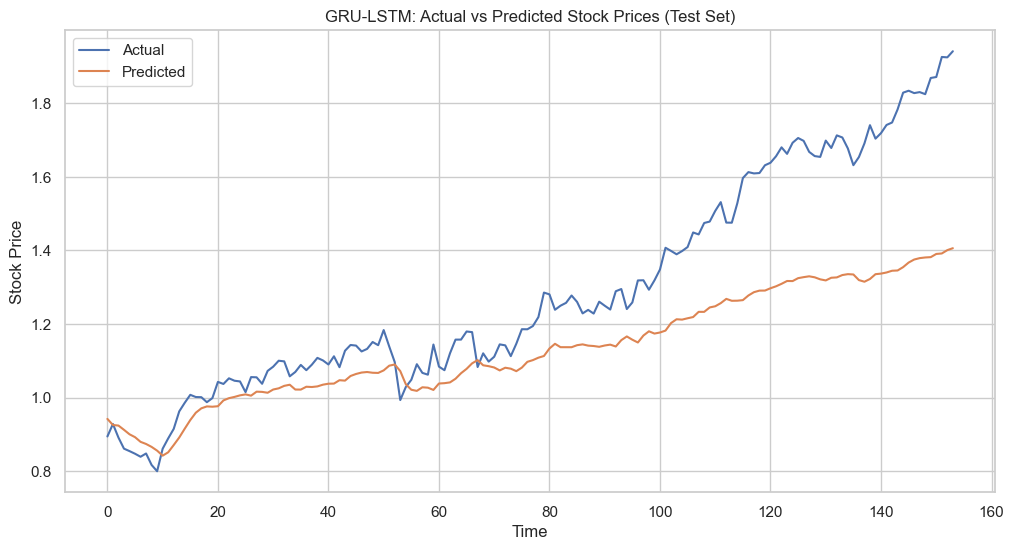


Results for GRU-LSTM:
  Best params: {'dense_units': 64, 'gru_units': 64, 'lstm_units': 100}
  Validation - MAE: 0.0765, RMSE: 0.0936, R2: 0.8577
  Test - MAE: 0.1651, RMSE: 0.2205, R2: 0.4399
Evaluating Attention GRU-LSTM model...

Training and evaluating Attention GRU-LSTM...


Hyperparameter Tuning: 100%|██████████| 18/18 [26:00<00:00, 86.68s/it]


Evaluating model...
Attention GRU-LSTM - Best params: {'dense_units': 64, 'gru_units': 128, 'lstm_units': 100}
Attention GRU-LSTM - Validation: MAE: 0.1089, RMSE: 0.1302, R2: 0.7249
Attention GRU-LSTM - Test: MAE: 0.1982, RMSE: 0.2652, R2: 0.1902


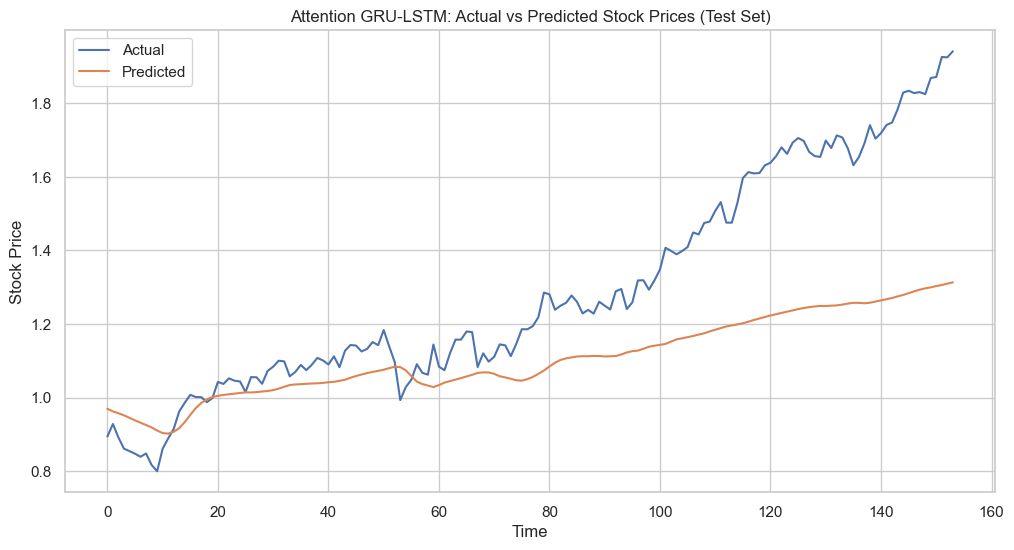


Results for Attention GRU-LSTM:
  Best params: {'dense_units': 64, 'gru_units': 128, 'lstm_units': 100}
  Validation - MAE: 0.1089, RMSE: 0.1302, R2: 0.7249
  Test - MAE: 0.1982, RMSE: 0.2652, R2: 0.1902
Evaluating Attention LSTM-CNN model...

Training and evaluating Attention LSTM-CNN...


Hyperparameter Tuning: 100%|██████████| 54/54 [33:10<00:00, 36.86s/it]


Evaluating model...
Attention LSTM-CNN - Best params: {'conv_filters': 128, 'conv_kernel_size': 3, 'dense_units': 64, 'lstm_units': 100}
Attention LSTM-CNN - Validation: MAE: 0.0568, RMSE: 0.0724, R2: 0.9149
Attention LSTM-CNN - Test: MAE: 0.0901, RMSE: 0.1059, R2: 0.8709


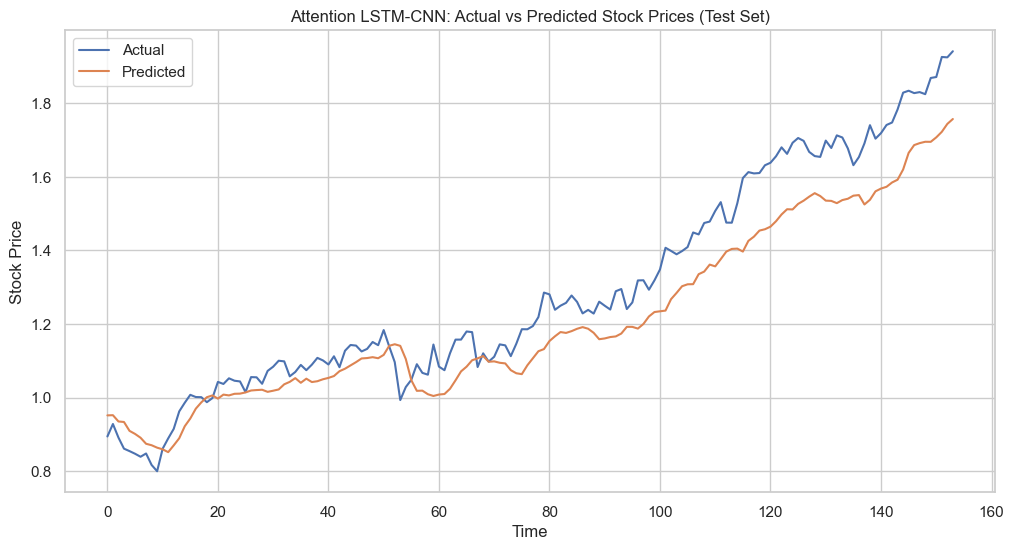


Results for Attention LSTM-CNN:
  Best params: {'conv_filters': 128, 'conv_kernel_size': 3, 'dense_units': 64, 'lstm_units': 100}
  Validation - MAE: 0.0568, RMSE: 0.0724, R2: 0.9149
  Test - MAE: 0.0901, RMSE: 0.1059, R2: 0.8709
Evaluating DeepESN model...

Training and evaluating DeepESN...


Hyperparameter Tuning:  98%|█████████▊| 239/243 [1:50:24<02:39, 39.81s/it]  

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from models import *
from tqdm import tqdm
from tqdm.keras import TqdmCallback

def prepare_sequences(data, features, target, sequence_length):
    X = np.lib.stride_tricks.sliding_window_view(data[features].values, (sequence_length, len(features)))
    y = data[target].values[sequence_length:]
    return X.reshape(-1, sequence_length, len(features)), y

def evaluate_model(y_true, y_pred):
    return (
        mean_absolute_error(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        r2_score(y_true, y_pred)
    )

def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def create_model(model_fn, input_shape, **kwargs):
    if model_fn.__name__ == 'DeepESN':
        return model_fn(n_inputs=input_shape[-1], **kwargs)
    return model_fn(input_shape, **kwargs)

def train_and_evaluate_model(model_fn, input_shape, params, X_train, y_train, X_val, y_val):
    model = create_model(model_fn, input_shape, **params)
    
    if model_fn.__name__ == 'DeepESN':
        model.fit(X_train, y_train)
        val_loss = mean_squared_error(y_val, model.predict(X_val))
    else:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
        
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val, y_val),
            # callbacks=[early_stopping, lr_scheduler],
            verbose=0  
        )
        val_loss = min(history.history['val_loss'])
    
    return model, val_loss

def custom_hyperparameter_tuning(model_fn, param_grid, X_train, y_train, X_val, y_val, input_shape):
    param_list = list(ParameterGrid(param_grid))
    
    best_model = None
    best_val_loss = float('inf')
    best_params = None
    
    for params in tqdm(param_list, desc="Hyperparameter Tuning"):
        model, val_loss = train_and_evaluate_model(model_fn, input_shape, params, X_train, y_train, X_val, y_val)
        if val_loss < best_val_loss:
            best_model = model
            best_val_loss = val_loss
            best_params = params
    
    return best_model, best_params

def train_and_evaluate(model_fn, X_train, y_train, X_val, y_val, X_test, y_test, model_name, param_grid=None):
    print(f"\nTraining and evaluating {model_name}...")
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    if param_grid:
        model, best_params = custom_hyperparameter_tuning(
            model_fn, param_grid, X_train, y_train, X_val, y_val, input_shape
        )
    else:
        best_params = {}
        model = create_model(model_fn, input_shape)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
        
        model.fit(X_train, y_train, epochs=100, batch_size=32, 
                  validation_data=(X_val, y_val), 
                #   callbacks=[early_stopping, lr_scheduler], 
                  verbose=0)
    
    print("Evaluating model...")
    if model_name == "DeepESN":
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
    else:
        y_val_pred = model.predict(X_val, verbose=0)
        y_test_pred = model.predict(X_test, verbose=0)
    
    val_metrics = evaluate_model(y_val, y_val_pred)
    test_metrics = evaluate_model(y_test, y_test_pred)
    
    print(f"{model_name} - Best params: {best_params}")
    print(f"{model_name} - Validation: MAE: {val_metrics[0]:.4f}, RMSE: {val_metrics[1]:.4f}, R2: {val_metrics[2]:.4f}")
    print(f"{model_name} - Test: MAE: {test_metrics[0]:.4f}, RMSE: {test_metrics[1]:.4f}, R2: {test_metrics[2]:.4f}")
    
    plot_results(y_test, y_test_pred, f'{model_name}: Actual vs Predicted Stock Prices (Test Set)')
    
    return val_metrics + test_metrics + (best_params,)

print("Preparing data...")

def evaluate_gru_lstm():
    print("Evaluating GRU-LSTM model...")
    results = train_and_evaluate(gru_lstm, X_train, y_train, X_val, y_val, X_test, y_test, "GRU-LSTM", gru_lstm_param_grid)
    print_results("GRU-LSTM", results)

def evaluate_att_gru_lstm():
    print("Evaluating Attention GRU-LSTM model...")
    results = train_and_evaluate(att_gru_lstm, X_train, y_train, X_val, y_val, X_test, y_test, "Attention GRU-LSTM", att_gru_lstm_param_grid)
    print_results("Attention GRU-LSTM", results)

def evaluate_att_lstm_cnn():
    print("Evaluating Attention LSTM-CNN model...")
    results = train_and_evaluate(att_lstm_cnn, X_train, y_train, X_val, y_val, X_test, y_test, "Attention LSTM-CNN", att_lstm_cnn_param_grid)
    print_results("Attention LSTM-CNN", results)

def evaluate_deep_esn():
    print("Evaluating DeepESN model...")
    results = train_and_evaluate(DeepESN, X_train, y_train, X_val, y_val, X_test, y_test, "DeepESN", deep_esn_param_grid)
    print_results("DeepESN", results)

def evaluate_tcn():
    print("Evaluating TCN model...")
    results = train_and_evaluate(tcn, X_train, y_train, X_val, y_val, X_test, y_test, "TCN", tcn_param_grid)
    print_results("TCN", results)

def print_results(model_name, results):
    val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2, best_params = results
    print(f"\nResults for {model_name}:")
    print(f"  Best params: {best_params}")
    print(f"  Validation - MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R2: {val_r2:.4f}")
    print(f"  Test - MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")

# You can now run these functions individually in separate cells
evaluate_gru_lstm()
evaluate_att_gru_lstm()
evaluate_att_lstm_cnn()
# evaluate_deep_esn()
# evaluate_tcn()

Evaluating DeepESN model...

Training and evaluating DeepESN...


Hyperparameter Tuning: 100%|██████████| 243/243 [1:44:07<00:00, 25.71s/it]


Evaluating model...
DeepESN - Best params: {'leaking_rate': 0.8, 'n_layers': 2, 'n_reservoir': 100, 'sparsity': 0.2, 'spectral_radius': 0.8}
DeepESN - Validation: MAE: 0.0499, RMSE: 0.0615, R2: 0.9386
DeepESN - Test: MAE: 0.1069, RMSE: 0.1467, R2: 0.7522


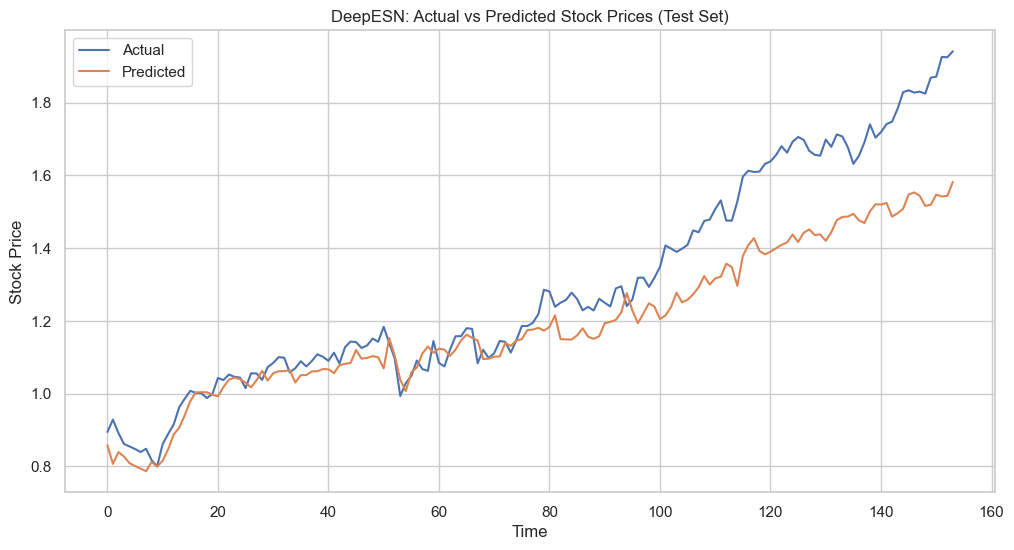


Results for DeepESN:
  Best params: {'leaking_rate': 0.8, 'n_layers': 2, 'n_reservoir': 100, 'sparsity': 0.2, 'spectral_radius': 0.8}
  Validation - MAE: 0.0499, RMSE: 0.0615, R2: 0.9386
  Test - MAE: 0.1069, RMSE: 0.1467, R2: 0.7522
Evaluating TCN model...

Training and evaluating TCN...


Hyperparameter Tuning:   0%|          | 0/162 [00:00<?, ?it/s]

Hyperparameter Tuning:  38%|███▊      | 62/162 [1:12:42<1:57:15, 70.36s/it] 


KeyboardInterrupt: 

In [7]:
evaluate_deep_esn()


Evaluating TCN model...

Training and evaluating TCN...


Hyperparameter Tuning: 100%|██████████| 54/54 [3:54:41<00:00, 260.77s/it]  


Evaluating model...
TCN - Best params: {'dilations': [1, 2, 4, 8, 16, 32], 'kernel_size': 3, 'learning_rate': 0.01, 'nb_filters': 32, 'nb_stacks': 1}
TCN - Validation: MAE: 0.0479, RMSE: 0.0604, R2: 0.9408
TCN - Test: MAE: 0.0992, RMSE: 0.1225, R2: 0.8271


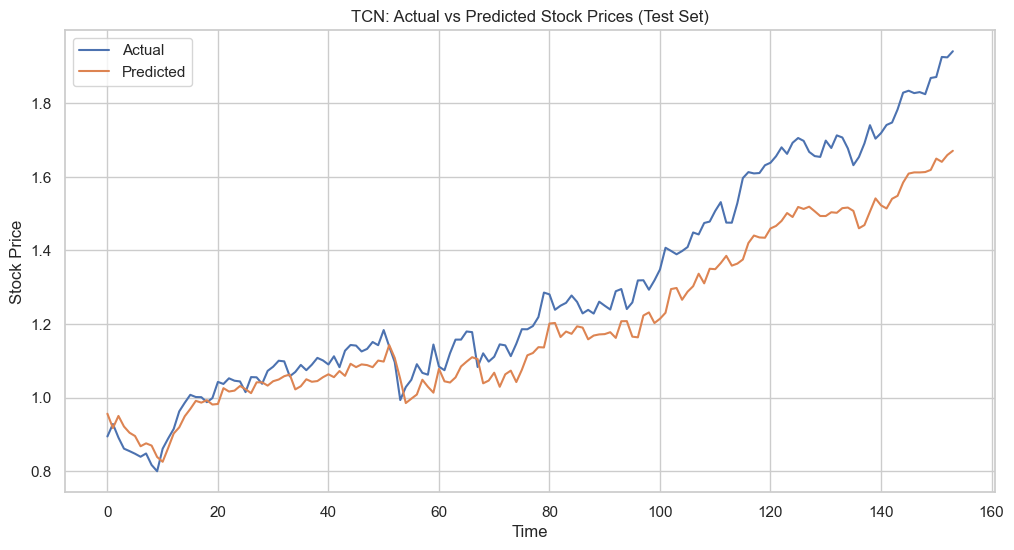


Results for TCN:
  Best params: {'dilations': [1, 2, 4, 8, 16, 32], 'kernel_size': 3, 'learning_rate': 0.01, 'nb_filters': 32, 'nb_stacks': 1}
  Validation - MAE: 0.0479, RMSE: 0.0604, R2: 0.9408
  Test - MAE: 0.0992, RMSE: 0.1225, R2: 0.8271


In [16]:
evaluate_tcn()